<a href="https://colab.research.google.com/github/Retmixer/FuelDataSet/blob/main/FuelDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Настройка визуализации
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

#  ЗАГРУЗКА ДАННЫХ
print("Загрузка данных об автомобилях...")
df = pd.read_csv('fuel.csv')

Загрузка данных об автомобилях...


In [5]:

#  ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ
print(f"Размерность данных: {df.shape}")
print("\nПервые 5 строк:")
(df.head())

print("\nИнформация о данных:")
df.info()

print("\nСтатистика числовых признаков:")
(df.describe())

Размерность данных: (16399, 81)

Первые 5 строк:

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16399 entries, 0 to 16398
Data columns (total 81 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   vehicle_id                         16399 non-null  int64  
 1   year                               16399 non-null  int64  
 2   make                               16399 non-null  object 
 3   model                              16399 non-null  object 
 4   class                              16399 non-null  object 
 5   drive                              15219 non-null  object 
 6   transmission                       16397 non-null  object 
 7   transmission_type                  6295 non-null   object 
 8   engine_index                       16399 non-null  int64  
 9   engine_descriptor                  15500 non-null  object 
 10  engine_cylinders                   16396 non-nu

,vehicle_id,year,engine_index,engine_cylinders,engine_displacement,supercharger,fuel_type_2,city_mpg_ft1,unrounded_city_mpg_ft1,city_mpg_ft2,...,hours_to_charge_ac_240v,composite_city_mpg,composite_highway_mpg,composite_combined_mpg,range_ft1,city_range_ft1,highway_range_ft1,range_ft2,city_range_ft2,highway_range_ft2
count,16399.000000,16399.000000,16399.000000,16396.000000,16397.000000,0.0,0.0,16398.000000,16398.0,16398.0,...,16398.0,16398.0,16398.0,16398.0,16398.0,16398.0,16398.0,0.0,16398.0,16398.0
mean,9984.820843,1989.621501,20335.821635,5.532996,3.231713,NaN,NaN,17.278083,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
std,8169.890547,4.081330,22386.848818,1.667499,1.422159,NaN,NaN,4.545354,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
min,1.000000,1984.000000,0.000000,2.000000,1.000000,NaN,NaN,6.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
25%,4100.500000,1986.000000,3710.000000,4.000000,2.100000,NaN,NaN,15.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
50%,8200.000000,1989.000000,4850.000000,6.000000,2.800000,NaN,NaN,17.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
75%,12299.500000,1993.000000,41050.000000,6.000000,4.300000,NaN,NaN,20.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
max,29683.000000,1998.000000,69102.000000,12.000000,8.000000,NaN,NaN,44.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0



Пропущенные значения:


Text(0.5, 0, 'Процент пропусков (%)')

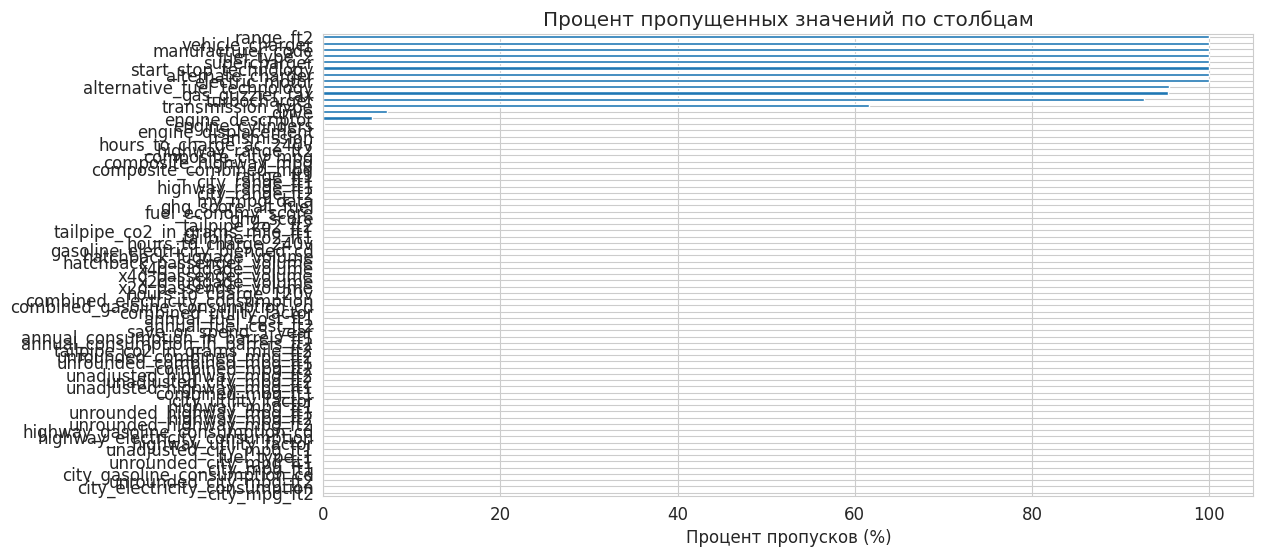

In [6]:
#  ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
print("\nПропущенные значения:")
missing = df.isnull().sum()
(missing[missing > 0])

# Визуализация пропусков
plt.figure(figsize=(12, 6))
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0]
missing_percent.sort_values(ascending=True).plot(kind='barh')
plt.title('Процент пропущенных значений по столбцам')
plt.xlabel('Процент пропусков (%)')

In [7]:
#  ВЫБОР ПРИЗНАКОВ ДЛЯ АНАЛИЗА
# Выберем наиболее интересные признаки для анализа расхода топлива
selected_features = [
    'make', 'model', 'year', 'class', 'drive', 'transmission',
    'engine_cylinders', 'engine_displacement', 'fuel_type',
    'city_mpg_ft1', 'highway_mpg_ft1', 'combined_mpg_ft1'
]

# Создаем новый датафрейм только с выбранными признаками
df_clean = df[selected_features].copy()

In [8]:
#  ОБРАБОТКА ПРОПУСКОВ
print("\nОбработка пропущенных значений...")

# Для числовых признаков заполняем медианой
numeric_cols = ['engine_cylinders', 'engine_displacement', 'city_mpg_ft1',
               'highway_mpg_ft1', 'combined_mpg_ft1']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Для категориальных заполняем модой
categorical_cols = ['make', 'model', 'class', 'drive', 'transmission', 'fuel_type']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')

print("Пропуски обработаны")


Обработка пропущенных значений...
Пропуски обработаны



Создание новой переменной 'eco_score'...
Новая переменная 'eco_score' успешно создана
Диапазон значений: 57.5 - 73.5
Среднее значение: 63.0

Анализ новой переменной:
Корреляция с combined_mpg_ft1: 0.915


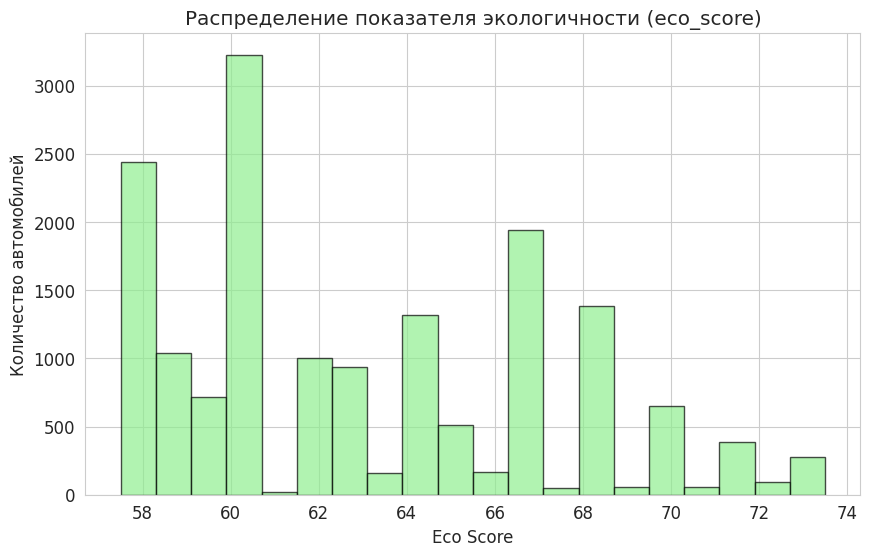

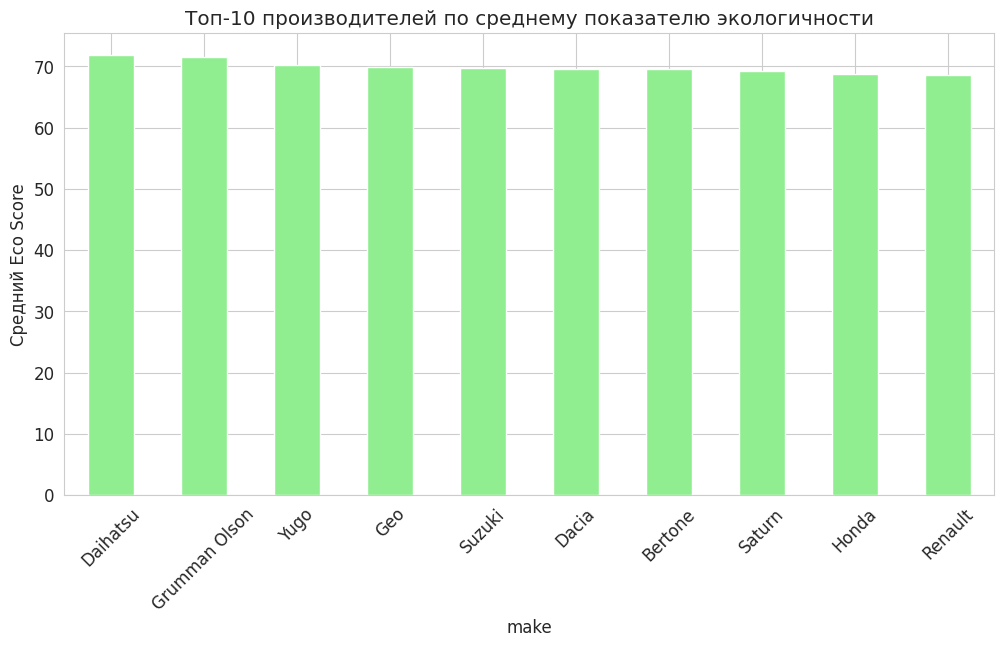

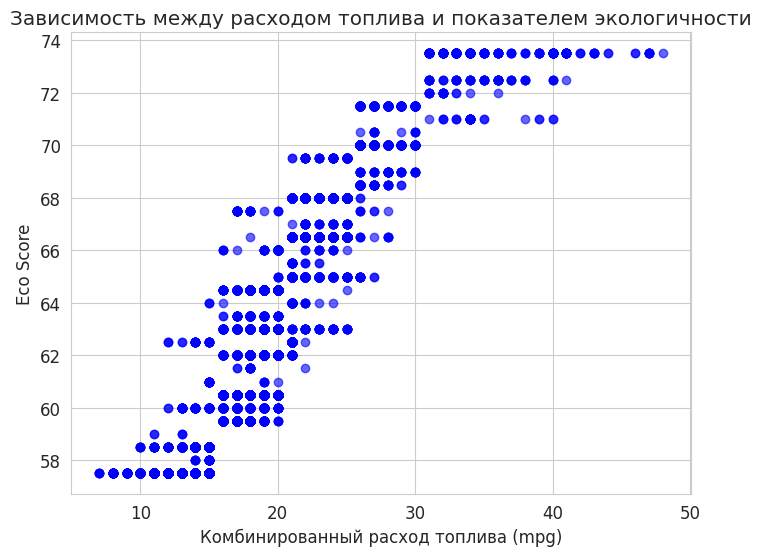

In [9]:
# СОЗДАНИЕ НОВОЙ ПЕРЕМЕННОЙ
print("\nСоздание новой переменной 'eco_score'...")

def calculate_eco_score(row):
    """
    Алгоритм расчета комплексного показателя экологичности автомобиля
    Включает оценку расхода топлива, объема двигателя и типа топлива
    """
    base_score = 50  # Базовый балл

    # 1. Оценка по комбинированному расходу топлива (40% веса)
    mpg_score = 0
    if pd.notna(row['combined_mpg_ft1']):
        if row['combined_mpg_ft1'] > 30:
            mpg_score = 30
        elif row['combined_mpg_ft1'] > 25:
            mpg_score = 25
        elif row['combined_mpg_ft1'] > 20:
            mpg_score = 20
        elif row['combined_mpg_ft1'] > 15:
            mpg_score = 15
        else:
            mpg_score = 10
    mpg_contribution = mpg_score * 0.4

    # 2. Оценка по объему двигателя (30% веса)
    engine_score = 0
    if pd.notna(row['engine_displacement']):
        if row['engine_displacement'] < 1.6:
            engine_score = 25
        elif row['engine_displacement'] < 2.0:
            engine_score = 20
        elif row['engine_displacement'] < 2.5:
            engine_score = 15
        elif row['engine_displacement'] < 3.0:
            engine_score = 10
        else:
            engine_score = 5
    engine_contribution = engine_score * 0.3

    # 3. Оценка по количеству цилиндров (20% веса)
    cylinder_score = 0
    if pd.notna(row['engine_cylinders']):
        if row['engine_cylinders'] <= 4:
            cylinder_score = 20
        elif row['engine_cylinders'] <= 6:
            cylinder_score = 15
        else:
            cylinder_score = 10
    cylinder_contribution = cylinder_score * 0.2

    # 4. Бонус за тип топлива (10% веса)
    fuel_bonus = 0
    if pd.notna(row['fuel_type']):
        fuel_type = str(row['fuel_type']).lower()
        if 'electric' in fuel_type or 'hybrid' in fuel_type:
            fuel_bonus = 10
        elif 'diesel' in fuel_type:
            fuel_bonus = 5
        elif 'regular' in fuel_type or 'premium' in fuel_type:
            fuel_bonus = 0
    fuel_contribution = fuel_bonus * 0.1

    # Итоговый расчет
    total_score = (base_score +
                  mpg_contribution +
                  engine_contribution +
                  cylinder_contribution +
                  fuel_contribution)

    # Ограничиваем диапазон 0-100
    return min(max(total_score, 0), 100)

# Применяем алгоритм к каждой строке датафрейма
df_clean['eco_score'] = df_clean.apply(calculate_eco_score, axis=1)

print("Новая переменная 'eco_score' успешно создана")
print(f"Диапазон значений: {df_clean['eco_score'].min():.1f} - {df_clean['eco_score'].max():.1f}")
print(f"Среднее значение: {df_clean['eco_score'].mean():.1f}")

# Анализ распределения новой переменной
plt.figure(figsize=(10, 6))
df_clean['eco_score'].hist(bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Распределение показателя экологичности (eco_score)')
plt.xlabel('Eco Score')
plt.ylabel('Количество автомобилей')

# Анализ eco_score по производителям
plt.figure(figsize=(12, 6))
eco_by_make = df_clean.groupby('make')['eco_score'].mean().sort_values(ascending=False).head(10)
eco_by_make.plot(kind='bar', color='lightgreen')
plt.title('Топ-10 производителей по среднему показателю экологичности')
plt.xticks(rotation=45)
plt.ylabel('Средний Eco Score')

# Корреляция eco_score с расходом топлива
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['combined_mpg_ft1'], df_clean['eco_score'], alpha=0.6, color='blue')
plt.xlabel('Комбинированный расход топлива (mpg)')
plt.ylabel('Eco Score')
plt.title('Зависимость между расходом топлива и показателем экологичности')

# Добавляем новую переменную в список для дальнейшего анализа
selected_features.append('eco_score')
numeric_cols.append('eco_score')

print("\nАнализ новой переменной:")
print(f"Корреляция с combined_mpg_ft1: {df_clean['eco_score'].corr(df_clean['combined_mpg_ft1']):.3f}")

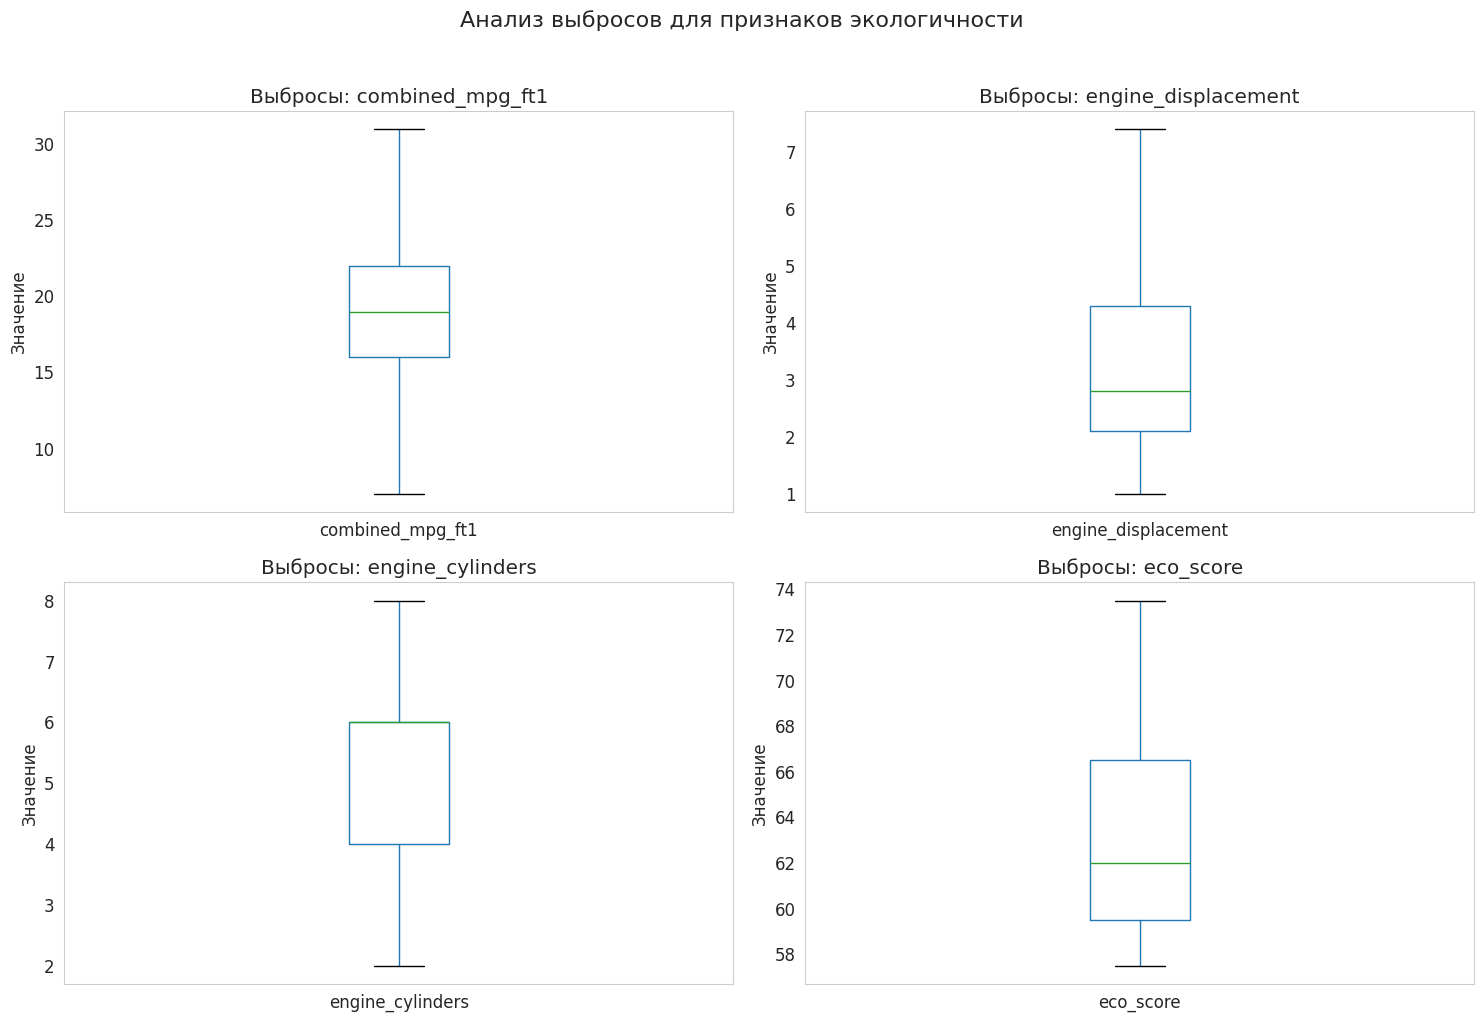

In [12]:
# Создаем список признаков для анализа
eco_features = ['combined_mpg_ft1', 'engine_displacement', 'engine_cylinders', 'eco_score']

# Создаем сетку графиков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Строим boxplot для каждого признака
for idx, col in enumerate(eco_features):
    df_clean.boxplot(column=col, ax=axes[idx], grid=False, showfliers=False)
    axes[idx].set_title(f'Выбросы: {col}')
    axes[idx].set_ylabel('Значение')

# Добавляем общий заголовок
plt.suptitle('Анализ выбросов для признаков экологичности', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Анализ распределений...


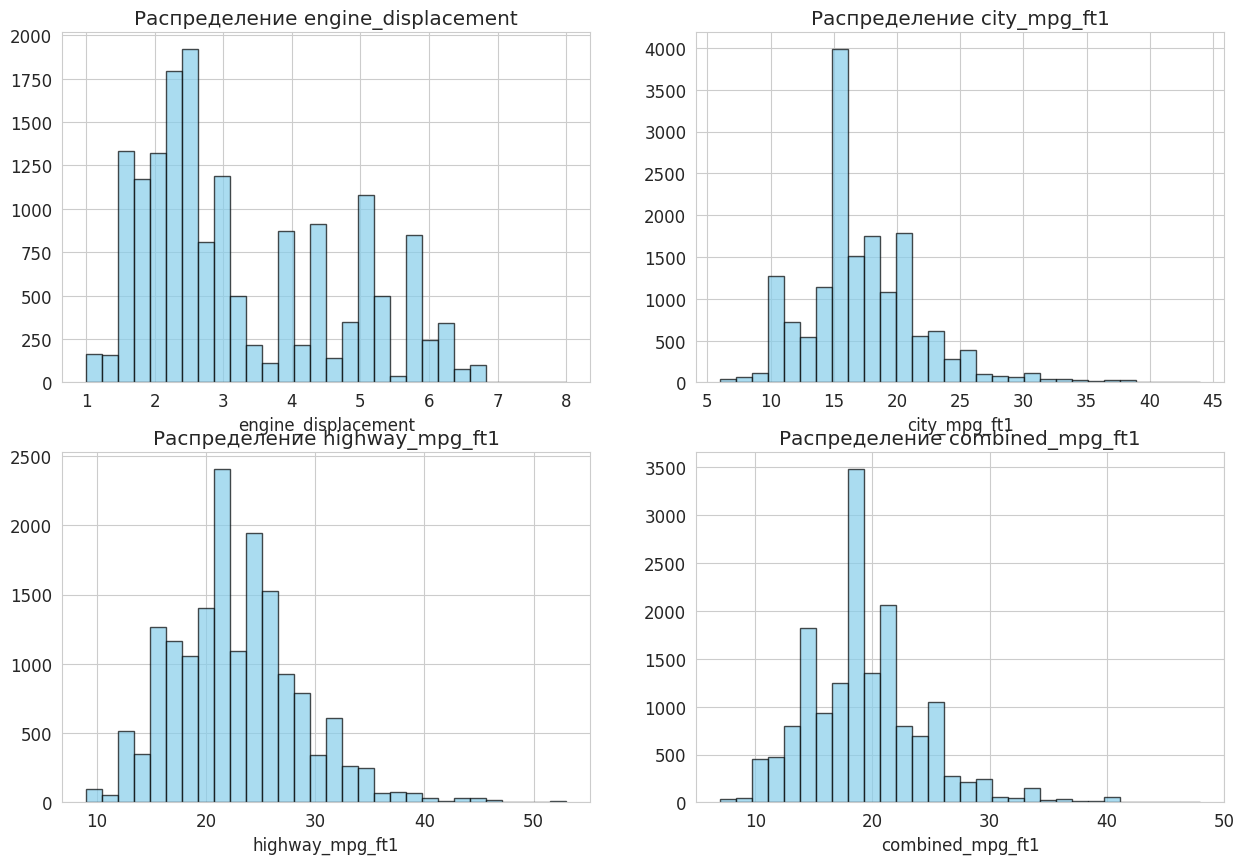

In [11]:
#  АНАЛИЗ РАСПРЕДЕЛЕНИЙ
print("\nАнализ распределений...")

# Гистограммы числовых признаков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

numeric_features_to_plot = ['engine_displacement', 'city_mpg_ft1', 'highway_mpg_ft1', 'combined_mpg_ft1']
for idx, col in enumerate(numeric_features_to_plot):
    if idx < len(axes):
        df_clean[col].hist(bins=30, ax=axes[idx], alpha=0.7, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Распределение {col}')
        axes[idx].set_xlabel(col)



Анализ выбросов...


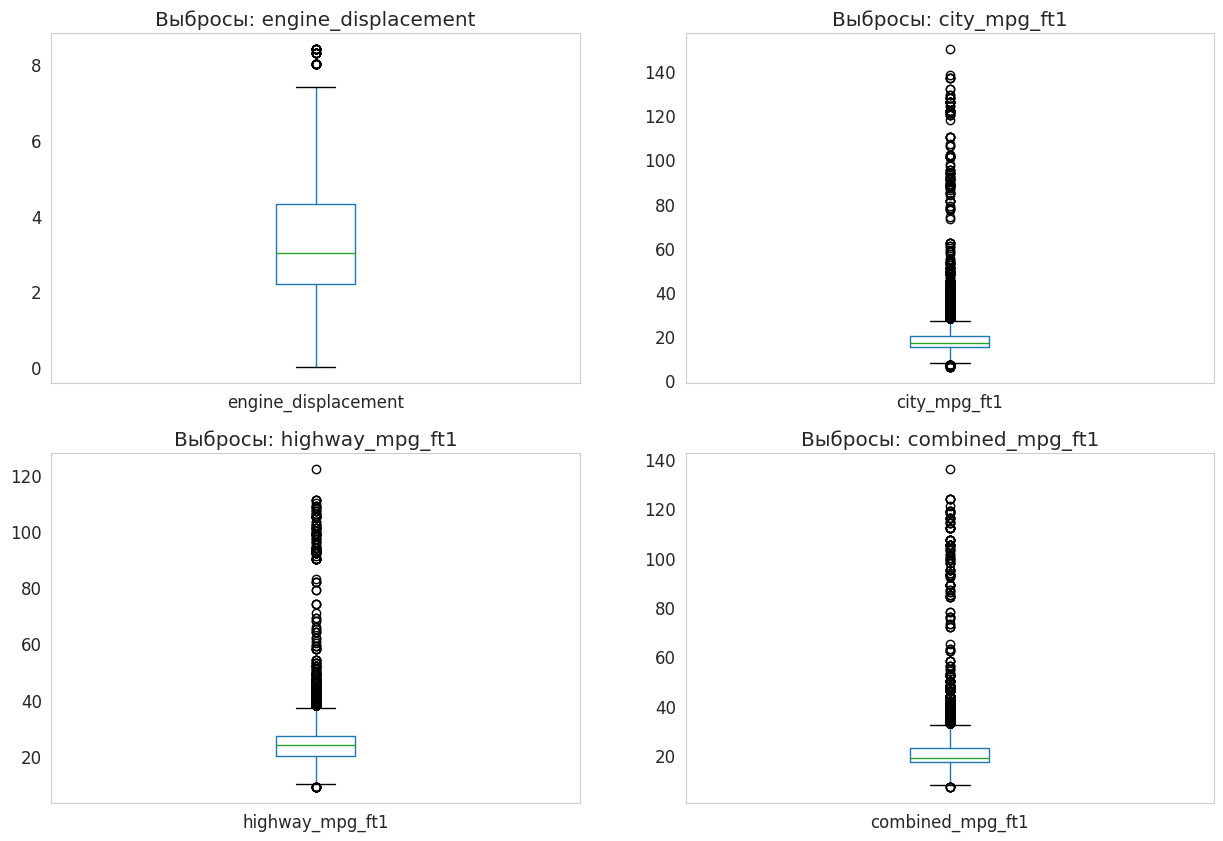

In [ ]:

#  АНАЛИЗ ВЫБРОСОВ
print("\nАнализ выбросов...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features_to_plot):
    if idx < len(axes):
        df_clean.boxplot(column=col, ax=axes[idx], grid=False)
        axes[idx].set_title(f'Выбросы: {col}')

In [ ]:
#ОБРАБОТКА ВЫБРОСОВ
print("\nОбработка выбросов...")

# Функция для обработки выбросов методом IQR
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Заменяем выбросы на граничные значения
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Обрабатываем выбросы в числовых признаках
for col in numeric_cols:
    if col in df_clean.columns:
        # Подсчет выбросов до обработки
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_before = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()

        # Обработка выбросов
        df_clean = handle_outliers_iqr(df_clean, col)

        # Подсчет выбросов после обработки
        outliers_after = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        print(f" {col}: {outliers_before} -> {outliers_after} выбросов")

print("Обработка выбросов завершена")


Обработка выбросов...
 engine_cylinders: 735 -> 0 выбросов
 engine_displacement: 43 -> 0 выбросов
 city_mpg_ft1: 1451 -> 0 выбросов
 highway_mpg_ft1: 893 -> 0 выбросов
 combined_mpg_ft1: 919 -> 0 выбросов
 eco_score: 0 -> 0 выбросов
Обработка выбросов завершена



Корреляционный анализ...


Text(0.5, 1.0, 'Матрица корреляций')

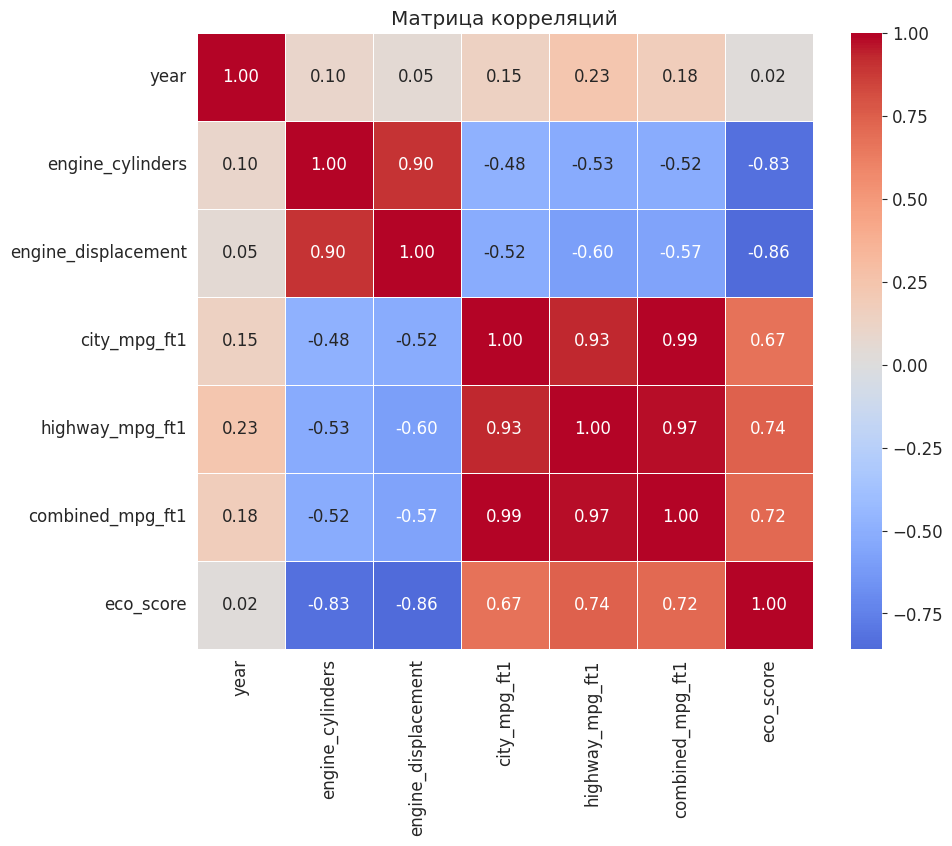

In [ ]:
# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
print("\nКорреляционный анализ...")

# Выбираем только числовые признаки для корреляционной матрицы
numeric_df = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица корреляций')


Анализ по производителям...


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Tesla'),
  Text(1, 0, 'CODA Automotive'),
  Text(2, 0, 'BYD'),
  Text(3, 0, 'Azure Dynamics'),
  Text(4, 0, 'smart'),
  Text(5, 0, 'Fiat'),
  Text(6, 0, 'Daihatsu'),
  Text(7, 0, 'Grumman Olson'),
  Text(8, 0, 'MINI'),
  Text(9, 0, 'Scion')])

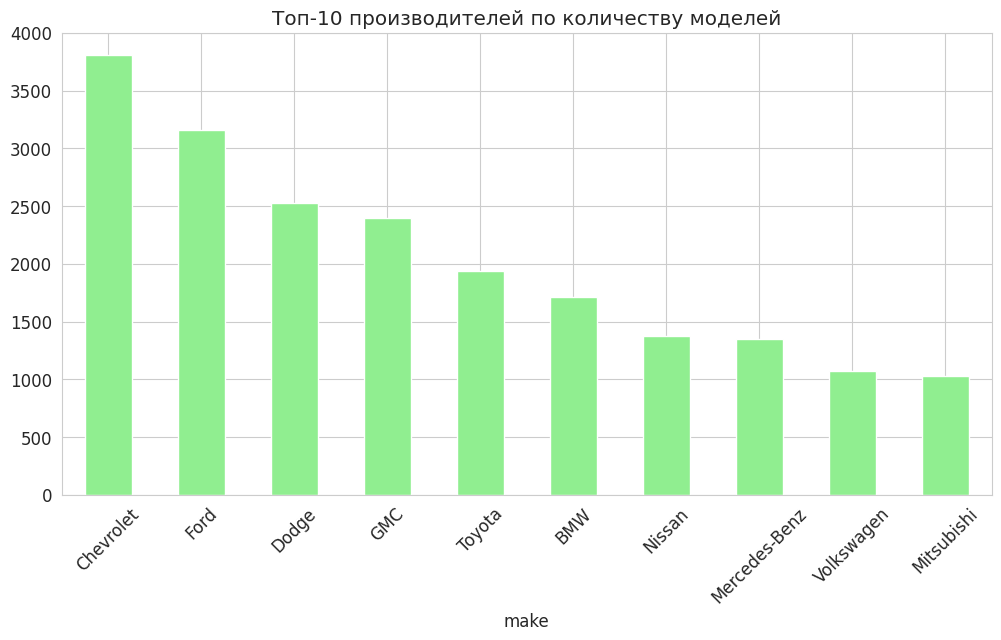

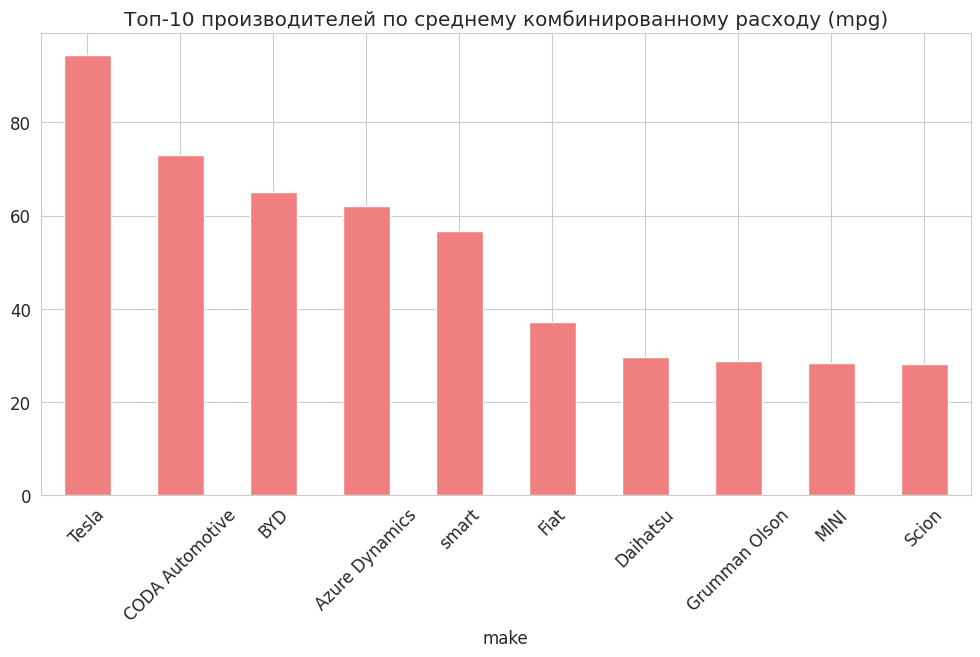

In [ ]:
#  АНАЛИЗ ПО ПРОИЗВОДИТЕЛЯМ
print("\nАнализ по производителям...")

# Топ-10 производителей по количеству моделей
top_makes = df_clean['make'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_makes.plot(kind='bar', color='lightgreen')
plt.title('Топ-10 производителей по количеству моделей')
plt.xticks(rotation=45)

# Средний расход топлива по производителям
plt.figure(figsize=(12, 6))
df_grouped = df_clean.groupby('make')['combined_mpg_ft1'].mean().sort_values(ascending=False).head(10)
df_grouped.plot(kind='bar', color='lightcoral')
plt.title('Топ-10 производителей по среднему комбинированному расходу (mpg)')
plt.xticks(rotation=45)


Анализ по типу топлива...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Regular'),
  Text(1, 0, 'Diesel'),
  Text(2, 0, 'Premium'),
  Text(3, 0, 'CNG'),
  Text(4, 0, 'Electricity'),
  Text(5, 0, 'Gasoline or natural gas'),
  Text(6, 0, 'Gasoline or E85'),
  Text(7, 0, 'Gasoline or propane'),
  Text(8, 0, 'Premium or E85'),
  Text(9, 0, 'Premium Gas or Electricity'),
  Text(10, 0, 'Midgrade'),
  Text(11, 0, 'Regular Gas and Electricity'),
  Text(12, 0, 'Premium and Electricity'),
  Text(13, 0, 'Regular Gas or Electricity')])

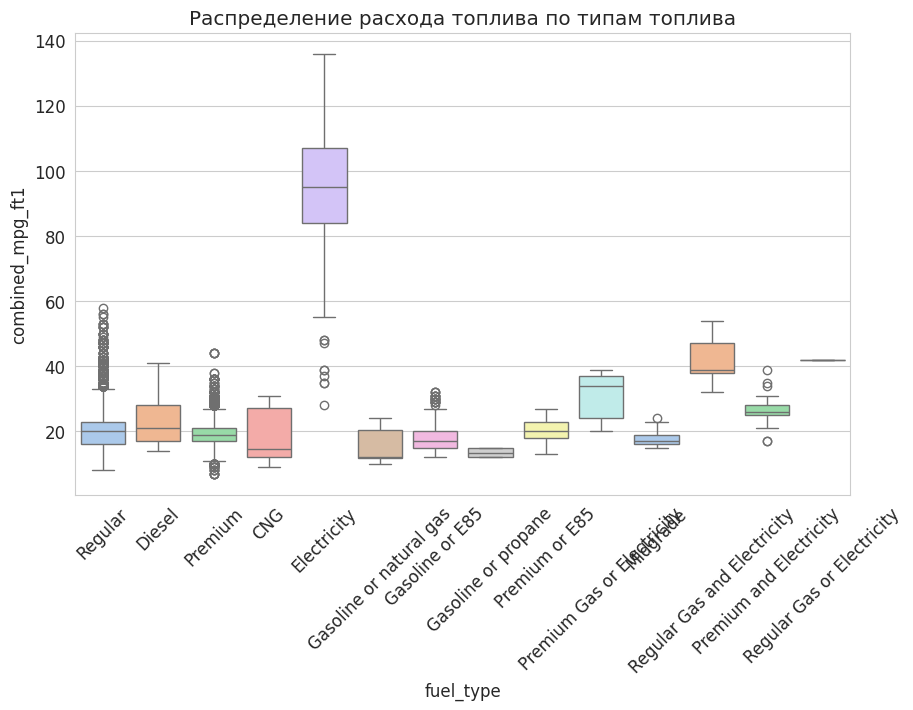

In [ ]:
#  АНАЛИЗ ПО ТИПУ ТОПЛИВА
print("\nАнализ по типу топлива...")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='fuel_type', y='combined_mpg_ft1', palette='pastel')
plt.title('Распределение расхода топлива по типам топлива')
plt.xticks(rotation=45)

In [ ]:
# ПРЕДОБРАБОТКА ДЛЯ МОДЕЛИРОВАНИЯ
print("\nПредобработка данных...")

df_model = df_clean.copy()

# Кодируем категориальные переменные
label_encoders = {}
for col in categorical_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Масштабируем числовые признаки
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model[numeric_cols])
df_model[numeric_cols] = scaled_features

print("Данные подготовлены для моделирования")


Предобработка данных...
Данные подготовлены для моделирования



Отбор наиболее важных признаков...
Отобрано 5 признаков:
  1. year (score: 1408.24)
  2. engine_cylinders (score: 44676.79)
  3. engine_displacement (score: 54537.14)
  4. combined_mpg_ft1 (score: -1100235162812326400.00)
  5. eco_score (score: 199008.43)


Text(0.5, 0, 'F-score')

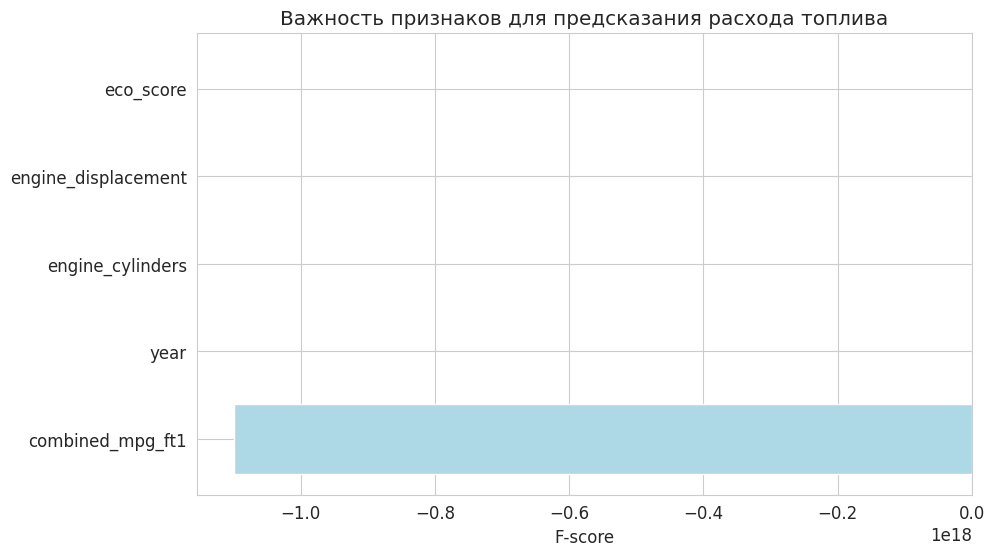

In [ ]:
# ОТБОР ПРИЗНАКОВ
print("\nОтбор наиболее важных признаков...")

# Готовим данные для отбора признаков
feature_cols = [col for col in df_model.columns if col not in
               ['make', 'model', 'class', 'drive', 'transmission', 'fuel_type',
                'city_mpg_ft1', 'highway_mpg_ft1'] and 'encoded' not in col]

X = df_model[feature_cols]
y = df_model['combined_mpg_ft1']  # Целевая переменная - комбинированный расход

# Отбираем топ-8 признаков
selector = SelectKBest(score_func=f_regression, k=min(8, len(feature_cols)))
X_selected = selector.fit_transform(X, y)
selected_features_names = X.columns[selector.get_support()]

print(f"Отобрано {len(selected_features_names)} признаков:")
for i, feature in enumerate(selected_features_names, 1):
    score = selector.scores_[selector.get_support()][i-1]
    print(f"  {i}. {feature} (score: {score:.2f})")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
feature_scores = pd.DataFrame({
    'feature': selected_features_names,
    'score': selector.scores_[selector.get_support()]
}).sort_values('score', ascending=True)

plt.barh(feature_scores['feature'], feature_scores['score'], color='lightblue')
plt.title('Важность признаков для предсказания расхода топлива')
plt.xlabel('F-score')

In [ ]:
#  СОЗДАНИЕ ФИНАЛЬНОГО ДАТАСЕТА
final_features = ['make', 'model', 'year', 'combined_mpg_ft1'] + selected_features_names.tolist()
final_dataset = df_clean[final_features].copy()

print(f"\nФинальный датасет создан")
print(f"Размер: {final_dataset.shape}")
print(f"Признаки: {final_features}")



Финальный датасет создан
Размер: (38113, 9)


"Признаки: ['make', 'model', 'year', 'combined_mpg_ft1', 'year', 'engine_cylinders', 'engine_displacement', 'combined_mpg_ft1', 'eco_score']"


Анализ тенденций по годам...


Text(0, 0.5, 'Средний расход (mpg)')

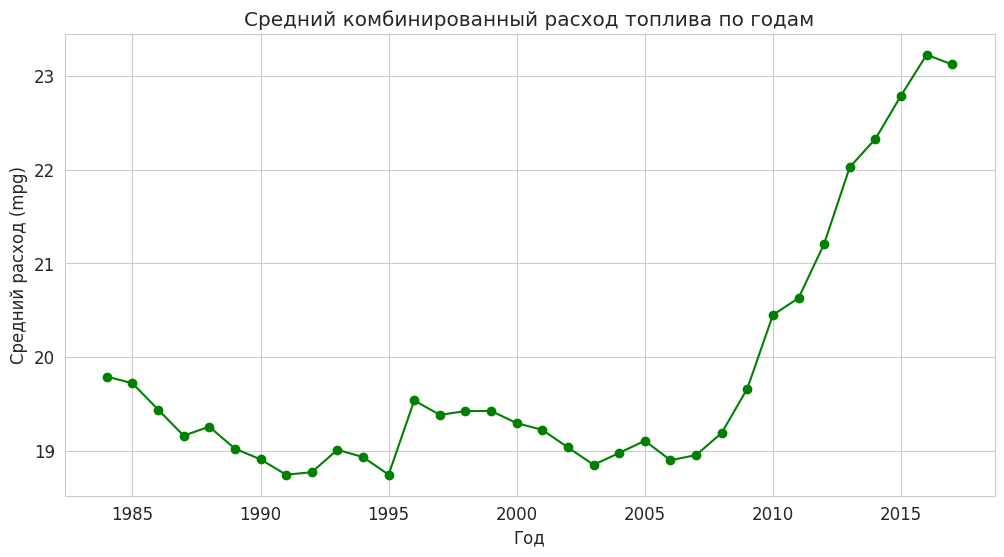

In [ ]:
#АНАЛИЗ ТЕНДЕНЦИЙ ПО ГОДАМ
print("\nАнализ тенденций по годам...")

plt.figure(figsize=(12, 6))
yearly_avg = df_clean.groupby('year')['combined_mpg_ft1'].mean()
yearly_avg.plot(kind='line', marker='o', color='green')
plt.title('Средний комбинированный расход топлива по годам')
plt.xlabel('Год')
plt.ylabel('Средний расход (mpg)')

In [ ]:

# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
final_dataset.to_csv('processed_car_data.csv', index=False, encoding='utf-8')

print("\n" + "="*50)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*50)
print(f"• Исходный размер данных: {df.shape}")
print(f"• Финальный размер данных: {final_dataset.shape}")
print(f"• Обработано пропущенных значений: {df.isnull().sum().sum() - df_clean.isnull().sum().sum()}")
print(f"• Отобрано ключевых признаков: {len(selected_features_names)}")
print(f"• Лучшие признаки: {', '.join(selected_features_names[:3])}")
print(f"• Данные сохранены в файл: 'processed_car_data.csv'")

# Показать финальный датасет
print("\nФИНАЛЬНЫЙ ДАТАСЕТ (первые 10 строк):")
(final_dataset.head(10))



ИТОГОВЫЙ ОТЧЕТ
• Исходный размер данных: (38113, 81)
• Финальный размер данных: (38113, 9)
• Обработано пропущенных значений: 449951
• Отобрано ключевых признаков: 5
• Лучшие признаки: year, engine_cylinders, engine_displacement
• Данные сохранены в файл: 'processed_car_data.csv'

ФИНАЛЬНЫЙ ДАТАСЕТ (первые 10 строк):


,make,model,year,combined_mpg_ft1,year,engine_cylinders,engine_displacement,combined_mpg_ft1,eco_score
0,Alfa Romeo,GT V6 2.5,1984,20.0,1984,6.0,2.5,20.0,62.0
1,Alfa Romeo,GT V6 2.5,1984,20.0,1984,6.0,2.5,20.0,62.0
2,Alfa Romeo,Spider Veloce 2000,1984,21.0,1984,4.0,2.0,21.0,66.5
3,Alfa Romeo,Spider Veloce 2000,1984,21.0,1984,4.0,2.0,21.0,66.5
4,AM General,DJ Po Vehicle 2WD,1984,17.0,1984,4.0,2.5,17.0,63.0
5,AM General,DJ Po Vehicle 2WD,1984,17.0,1984,4.0,2.5,17.0,63.0
6,AM General,FJ8c Post Office,1984,13.0,1984,6.0,4.2,13.0,58.5
7,AM General,FJ8c Post Office,1984,13.0,1984,6.0,4.2,13.0,58.5
8,American Motors Corporation,Eagle 4WD,1984,17.0,1984,6.0,4.2,17.0,60.5
9,American Motors Corporation,Eagle 4WD,1984,17.0,1984,6.0,4.2,17.0,60.5
